# How to read in and interpret Level 2 SIF data
This jupyter notebook will guide you how to use SIF Level 2 data (ungridded SIF retrievals for each individual satellite footprint) in your research. I will also go through some of the typical pitfalls and misconceptions in using the data. The examples will be based mostly on TROPOMI and OCO-2 data but can easily be adapted to also access GOME-2 and SCIAMACHY data. In fact, some of the provided readers will be easily adaptable to ingest any arbitrary Level 2 dataset in HDF5 (or netCDF4).

### Goals:
<li> Learn how to read in OCO-2 and TROPOMI data
<li> Learn that noise is normal and well characterized by the retrievals
<li> Extract data from specific regions and create time-series
<li> Learn how convert measurements at different wavelengths and times of day.

### Data format:
First of all, almost all scientific datasets are now provided in either HDF or netCDF formats. We currently use the latest standards, i.e. HDF5 and netCDF4 (which is basically a layer on top of HDF5, so any HDF5 reader can access netCDF datasets). Typically, datasets include comments and units as attributes, so that you know what you are dealing with even without a user guide. In python, there are very convenient tools to access these files, h5py (http://docs.h5py.org/en/stable/) and netCDF4 (http://unidata.github.io/netcdf4-python/). A good start to look at files in the beginning is to use viewing tools like:
<li> hdfview: https://support.hdfgroup.org/products/java/hdfview/
<li> panoply (great for actually viewing L3 files!): https://www.giss.nasa.gov/tools/panoply/
<li> you should also be able to use ncl tools: https://www.ncl.ucar.edu/ (not too familiar myself with those)


Setting up the Jupyter environment (typical imports)

In [1]:
#%matplotlib inline
## The usual packages (numpy, matplotlib, etc)
import matplotlib.pyplot as plt
import numpy as np
# nicer figures using ggg plot style.
plt.style.use('ggplot')
from IPython.core.display import HTML
from IPython.display import clear_output
from IPython.core.pylabtools import figsize
import datetime as dt

### Most important step, import all tools in the L2_tools.py file 
(take a look at this if you want to know what is under the hood)

In [2]:
# This file L2_tools.py is in the same folder here and will provide easy access to TROPOMI and OCO-2 L2 data 
from L2_tools import *

### Download data first:
paths for OCO-2 and TROPOMI data (in fact, the path just points to our internal structure of the ftp server at 
ftp://fluo.gps.caltech.edu/data/). So once you copy the folders (I suggest you learn how to use wget https://www.gnu.org/software/wget/ or curl https://www.tecmint.com/linux-curl-command-examples/)


In [3]:
# Please adapt to your local directories after having mirrored our ftp data (and extracted the ungridded TROPOMI files):
path_tropomi = '../data/TROPOMI/nc_ungridded/'

# This is still cumbersome, the units are part of the netCDF4 files but I hardcode them for now:
t_unit_tropomi = "seconds since 1970-01-01 00:00:00"
t_cal = u"gregorian"

In [4]:
# Let us read in some OCO-2 and TROPOMI data over a non-fluorescing region in the Sahara
# Define region boundaries for a part of the Sahara:
latMin = 20
latMax = 23
lonMin = 5
lonMax = 8

Now read in the data, two dictionaries for OCO-2 and TROPOMI were included in L2_tools.py, it basically just enables you to decides which fields to read in and can be adapted (actually to read in any kind of data)
The first entry should provide a path to all files you want to read (you can use wildcard!)

In [5]:
# TROPOMI will take a bit more time, be patient!
tropomi_sahara = L2(path_tropomi+'*2018-0[45678]*.nc', dict_tropomi,latMin, latMax, lonMin, lonMax )

The syntax for reading in data is as follows:
`data = L2(path_to_data, dictionary,latMin, latMax, lonMin, lonMax )`
Find some examples for the dictionary below (these can be adapted to read in GOME-2 data). The format describes the "key" as how you want to name the variable in your returned class and the "item" as the variable name of the HDF5 file. 

------
How does the reading routine work? It basically goes through the HDF5 files and uses a dictionary to decide which variables to read in. Then, it just concatenates all the data into a larger set and stores everything in a class (just think of it like a structure for now)

Take a sneak peak at the dictionaries used, they basically describe which variable to read in (2nd componend) and how to call them in the class structure (first component). These are very generic, so you use them to read in OCO-2 XCO2 lite files as well (just require a new dictionary). In the future, we may add the use of json files as dictionary input.

In [5]:
dict_tropomi

{'dcCorr': 'daily_correction_factor',
 'lat': 'lat',
 'lon': 'lon',
 'phaseAngle': 'phase_angle',
 'sif': 'sif',
 'sif_sigma': 'sif_err',
 'sza': 'sza',
 'time': 'TIME',
 'vza': 'vza'}

In [6]:
# First convert oco2 time units to a python time (this is a clunky step right now, need to automate later!)
tropomi_sahara.time_python = convert_time(tropomi_sahara.time, t_unit_tropomi, t_cal)

NameError: name 'tropomi_sahara' is not defined

Text(0.5, 1.0, 'TROPOMI (SIF at 740nm)')

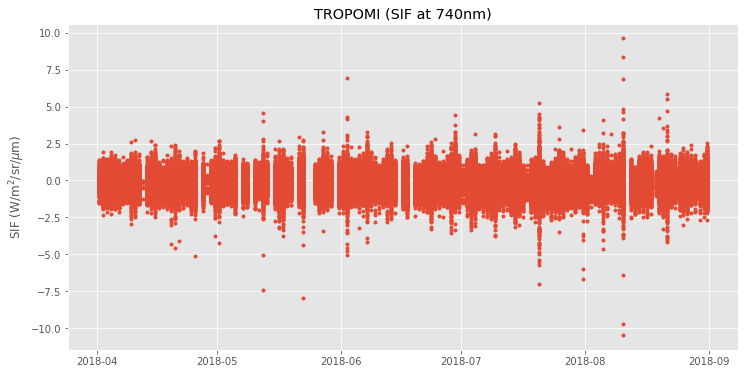

In [8]:
# now lets plot a timeseries
figsize(12,6)
plt.plot(tropomi_sahara.time_python, tropomi_sahara.sif,'.')
plt.ylabel('SIF (W/m$^2$/sr/$\mu$m)')
plt.title('TROPOMI (SIF at 740nm)')

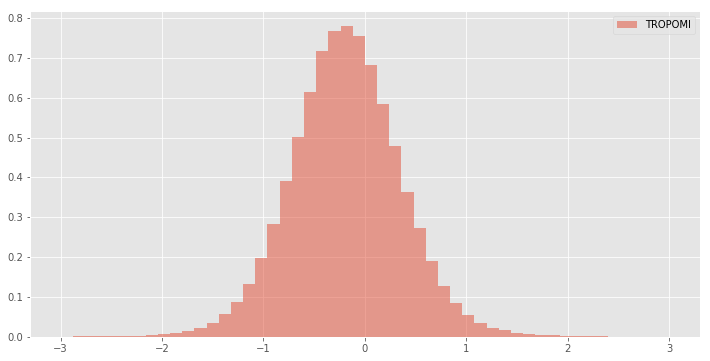

In [9]:
# let us look at a histogram
plt.hist(tropomi_sahara.sif,  50,range=(-3,3), density=True, alpha=0.5, label='TROPOMI')
plt.legend(loc=0)

## Does this make sense?
We looked at the Sahara and SIF should be around 0. The data looks very noisy, can we make use of that? Many users ask us what to do with negative data, this example will show you why it is dangerous to exclude negative data in SIF the SIF analysis

In [14]:
print('Standard deviation of measured TROPOMI SIF data in Sahara ' + str(np.std(tropomi_sahara.sif)) )
print('Expected standard deviation based on posteriori error ' + str(np.mean(tropomi_sahara.sif_sigma)) )

Standard deviation of measured TROPOMI SIF data in Sahara 0.5511246
Expected standard deviation based on posteriori error 0.54011494


In [13]:
print('Mean if we exclude negative data ' + str(np.mean(tropomi_sahara.sif[tropomi_sahara.sif>=0])))
print('True mean ' + str(np.mean(tropomi_sahara.sif)))

Mean if we exclude negative data 0.37125534
True mean -0.188487


You can see 2 things here: a) removing negative values is dangerous. If the true value is 0 and we have measurement noise, negative retrievals are not unphysical if they are within the posterior noise estimate; b) we sometimes have averages that are below  (e.g. -0.12 here). This can happen and really depends on the posterior bias correction. We are still working on this but removing small biases on the order of 0.1 is really hard.

-----

## Let's take a region with more SIF, e.g. Eastern North Carolina


In [70]:
# Define region boundaries (roughly ENC)
latMin_cb = 34.8
latMax_cb = 35.5
lonMin_cb = -78
lonMax_cb = -76

# full ENC
# latMin_cb = 34.063720
# latMax_cb = 35.229775
# lonMin_cb = -78.652436
# lonMax_cb = -77.080399

# Croatan National Forest
latMin_cb = 34.749717
latMax_cb = 34.951762
lonMin_cb = -77.211860
lonMax_cb = -76.970352

# Eastern NC from Wilmington to Beaufort including Water
# latMin_cb = 33.672924
# latMax_cb = 34.965403
# lonMin_cb = -78.113899
# lonMax_cb = -76.196812

# SC at similar lat as ENC box
# latMin_cb = 34.182868
# latMax_cb = 34.711967
# lonMin_cb = -81.867900
# lonMax_cb = -80.514915

# Uwharrie National Forest
# latMin_cb = 35.322980
# latMax_cb = 35.439823
# lonMin_cb = -80.056851
# lonMax_cb = -79.987691

# Ocean Bounding Box
# latMin_cb = 33.777807
# latMax_cb = 34.401182
# lonMin_cb = -77.162989
# lonMax_cb = -76.626571

In [71]:
tropomi_nc_coastal = L2(path_tropomi+'*2018-[01][0123456789]*.nc', dict_tropomi,latMin_cb, latMax_cb, lonMin_cb, lonMax_cb )

In [72]:
# Again, convert tedious times in the files to something you can work with in python
#oco2_iowa.time_python    = convert_time(oco2_iowa.time, t_unit_oco2, t_cal)
tropomi_nc_coastal.time_python = convert_time(tropomi_nc_coastal.time, t_unit_tropomi, t_cal)

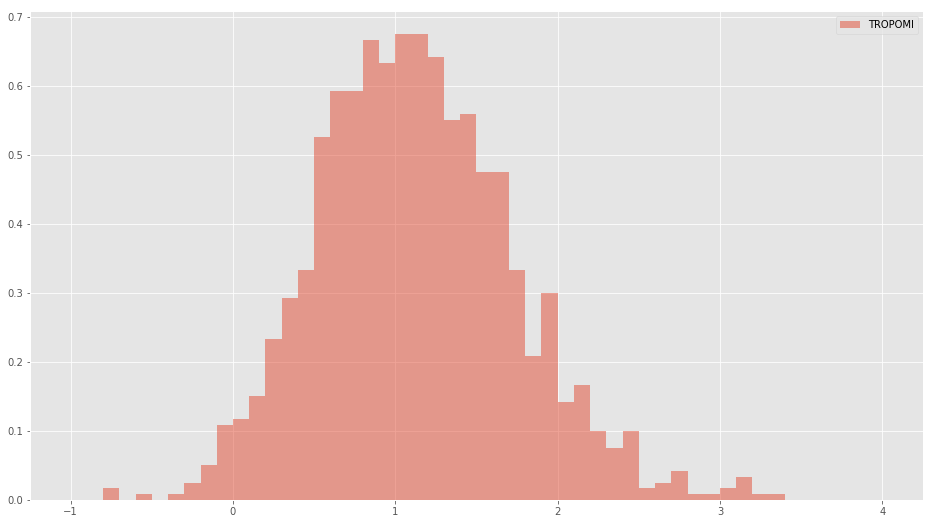

In [73]:
plt.hist(tropomi_nc_coastal.sif,  50,range=(-1,4), density=True, alpha=0.5, label='TROPOMI')
plt.legend(loc=0)

Text(0.5, 1.0, 'TROPOMI (SIF at 740nm)')

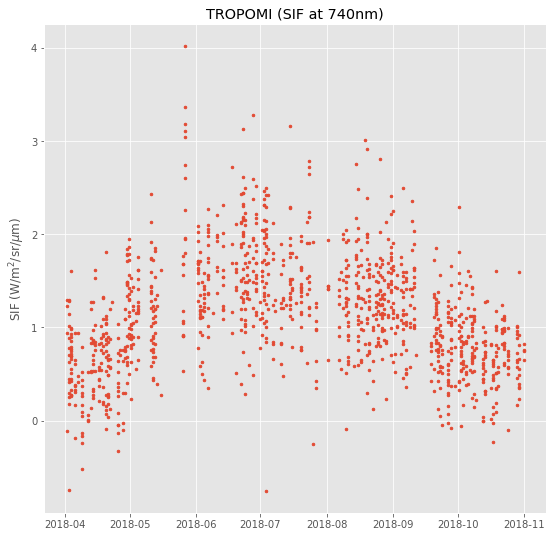

In [74]:
# now lets plot a timeseries
figsize(9,9)
plt.plot(tropomi_nc_coastal.time_python, tropomi_nc_coastal.sif,'.',markersize=5)
plt.ylabel('SIF (W/m$^2$/sr/$\mu$m)')
plt.title('TROPOMI (SIF at 740nm)')

### Phase angle
One important aspect affecting SIF is the phase angle as it largely determines the amount of sunlit leaves in the FOV of the instrument (maximum of a phase angle of 0, which is basically the hotspot of vegetation). More on this by Philipp.

Text(0.5, 1.0, 'TROPOMI time-series with PhaseAngle color-coded')

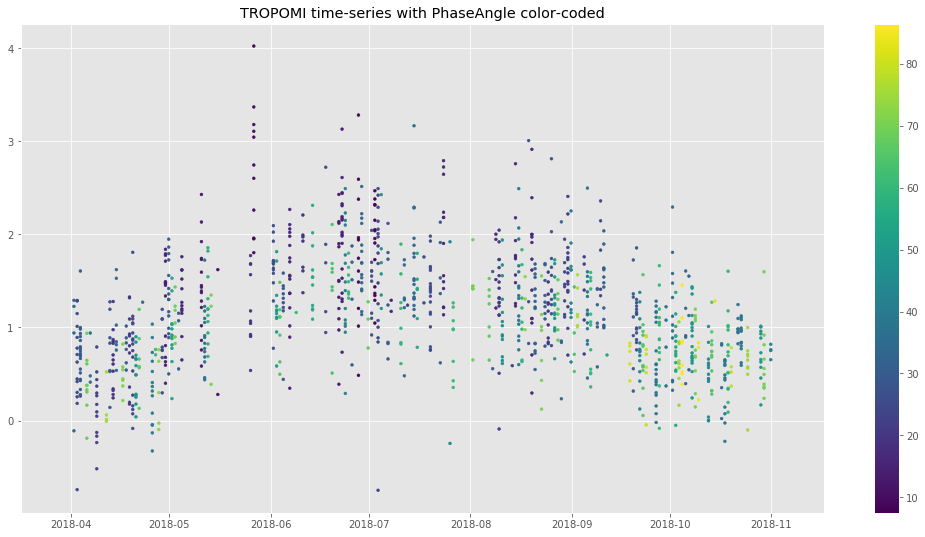

In [75]:
figsize(18,9)
plt.scatter(tropomi_nc_coastal.time_python, tropomi_nc_coastal.sif,s=8, c=np.abs(tropomi_nc_coastal.phaseAngle))
plt.colorbar()
plt.title('TROPOMI time-series with PhaseAngle color-coded')

well, we have "somewhat" more data points using TROPOMI:

In [76]:
print('Number of TROPOMI data points in NC: ' + str(len(tropomi_nc_coastal.sif)))

Number of TROPOMI data points in NC: 1200


---
## Let us compute timeseries from OCO-2 and TROPOMI data
You can see that individual data are too noisy to work with, thus we have to average. Looking at Iowa, we see that we have more than enough data for averaging. Now we can define a temporal resolution and create a running mean to drive down the noise (which should scale with $1/\sqrt{n}$):

In [77]:
# Let us define some averaging interval, get data every 3 days and create a running mean of +/- 3 days:
from datetime import datetime
# Define data range to smooth on (every 3 days)
dates = np.arange('2018-04', '2018-11', dtype='datetime64[3D]').astype(datetime)

In [78]:
# We used dates with a 3 day time-step and now use a +/- 3 day filter for the running mean:
#nc_timeseries_tropomi = sif_rMean(tropomi_nc.time_python, tropomi_nc.sif,dates, 7 )
#nc_inland_timeseries_tropomi = sif_rMean(tropomi_nc.time_python, tropomi_nc.sif,dates, 7 )
nc_coastal_timeseries_tropomi = sif_rMean(tropomi_nc_coastal.time_python, tropomi_nc_coastal.sif,dates, 7 )
#nc_inland_timeseries_tropomi = sif_rMean(tropomi_nc.time_python, tropomi_nc.sif,dates, 7 )

In [17]:
da.rolling(time=3).mean()

NameError: name 'da' is not defined

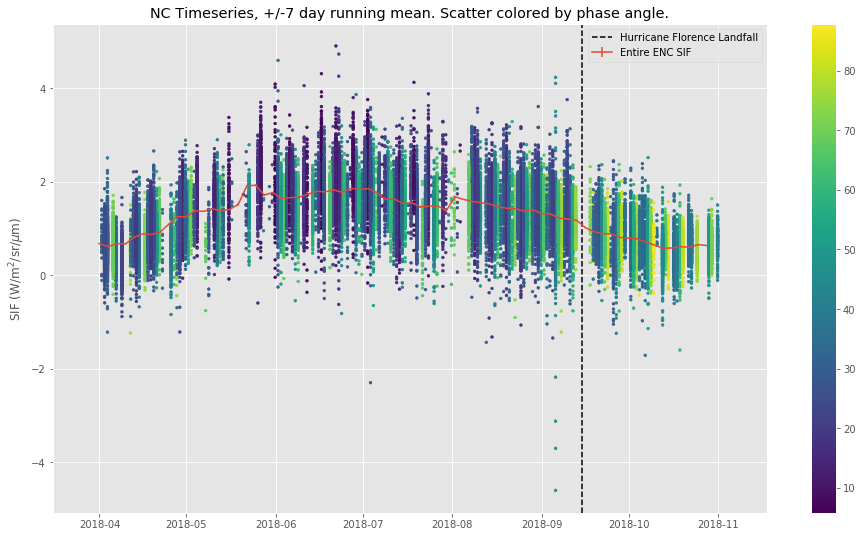

In [69]:
figsize(16,9)
plt.scatter(tropomi_nc_coastal.time_python, tropomi_nc_coastal.sif,s=8, c=np.abs(tropomi_nc_coastal.phaseAngle))
plt.colorbar()
#plt.errorbar(dates, nc_timeseries_tropomi.mean,yerr=nc_timeseries_tropomi.standard_error,  label='Coastal SIF')
plt.errorbar(dates, nc_coastal_timeseries_tropomi.mean,yerr=nc_coastal_timeseries_tropomi.standard_error,  label='Entire ENC SIF')
plt.axvline(x=dt.date(2018, 9, 15),label='Hurricane Florence Landfall', c='black', linestyle="dashed")
plt.ylabel('SIF (W/m$^2$/sr/$\mu$m)')
plt.legend(loc=0)
plt.title('NC Timeseries, +/-7 day running mean. Scatter colored by phase angle.')
plt.savefig("enc_sif_scatter.png", dpi=300)

Text(0.5, 1.0, 'NC Timeseries, +/-3 day running mean')

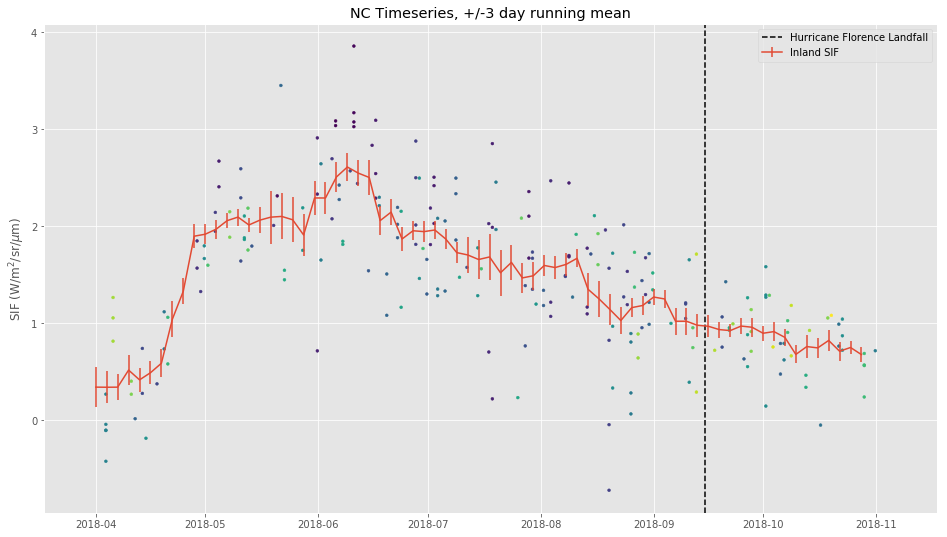

In [30]:
figsize(16,9)
plt.scatter(tropomi_nc.time_python, tropomi_nc.sif,s=8, c=np.abs(tropomi_nc.phaseAngle))
#plt.errorbar(dates, nc_timeseries_tropomi.mean,yerr=nc_timeseries_tropomi.standard_error,  label='Coastal SIF')
plt.errorbar(dates, nc_inland_timeseries_tropomi_2.mean,yerr=nc_inland_timeseries_tropomi_2.standard_error,  label='Inland SIF')
plt.axvline(x=dt.date(2018, 9, 15),label='Hurricane Florence Landfall', c='black', linestyle="dashed")
plt.ylabel('SIF (W/m$^2$/sr/$\mu$m)')
plt.legend(loc=0)
plt.title('NC Timeseries, +/-3 day running mean')

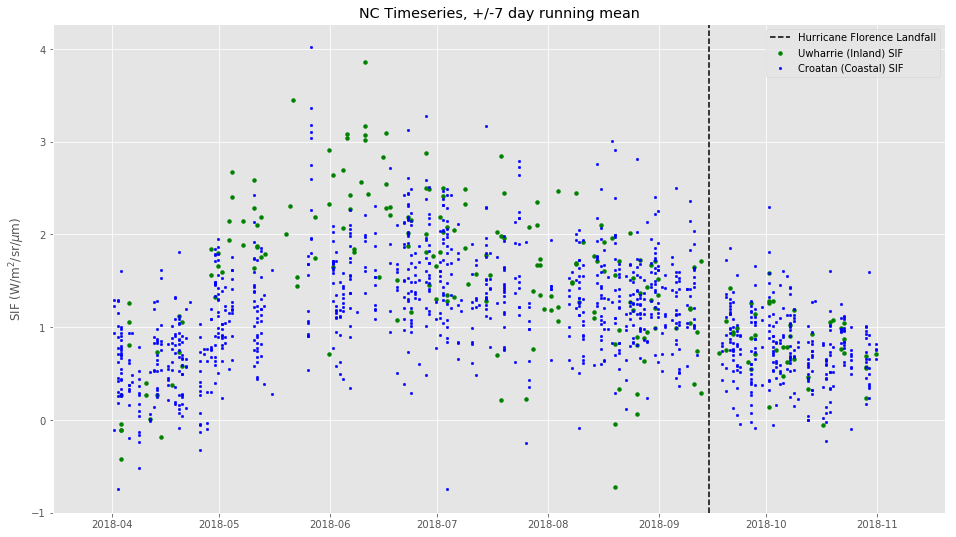

In [94]:
figsize(16,9)
plt.scatter(tropomi_nc.time_python, tropomi_nc.sif,s=15, c="green", label='Uwharrie (Inland) SIF')
plt.scatter(tropomi_nc_coastal.time_python, tropomi_nc_coastal.sif,s=6, c="blue", label='Croatan (Coastal) SIF')

#plt.errorbar(dates, nc_timeseries_tropomi.mean,yerr=nc_timeseries_tropomi.standard_error,  label='Coastal SIF')
#plt.errorbar(dates, nc_coastal_timeseries_tropomi.mean,yerr=nc_coastal_timeseries_tropomi.standard_error,  label='Coastal SIF')
#plt.errorbar(dates, nc_inland_timeseries_tropomi.mean,yerr=nc_inland_timeseries_tropomi.standard_error,  label='Inland SIF')
plt.axvline(x=dt.date(2018, 9, 15),label='Hurricane Florence Landfall', c='black', linestyle="dashed")
plt.ylabel('SIF (W/m$^2$/sr/$\mu$m)')
plt.legend(loc=0)
plt.title('NC Timeseries, +/-7 day running mean')
plt.savefig("croatan_uwharrie_sif_scatter.png", dpi=300)

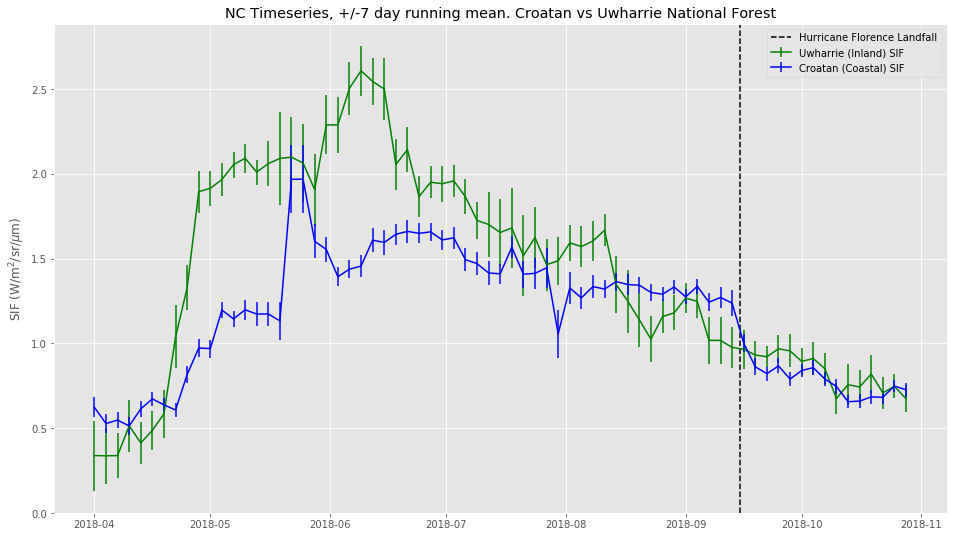

In [93]:
figsize(16,9)
plt.errorbar(dates, nc_inland_timeseries_tropomi.mean,yerr=nc_inland_timeseries_tropomi.standard_error, c='green', label='Uwharrie (Inland) SIF')
plt.errorbar(dates, nc_coastal_timeseries_tropomi.mean,yerr=nc_coastal_timeseries_tropomi.standard_error, c='blue', label='Croatan (Coastal) SIF')
plt.axvline(x=dt.date(2018, 9, 15),label='Hurricane Florence Landfall', c='black', linestyle="dashed")
plt.ylabel('SIF (W/m$^2$/sr/$\mu$m)')
plt.legend(loc=0)
plt.title('NC Timeseries, +/-7 day running mean. Croatan vs Uwharrie National Forest')
plt.savefig("croatan_uwharrie_sif.png", dpi=300)


----

## Correction for overpass time and length of day:
Another crucial impact is due to changes in the overpass time and how to relate the instantaenous SIF to a daily average. Our first simple approximations are just based on calculations of the ratio of a daily average PAR vs instantaenous PAR (assuming cloud free conditions). To first order, this should bring different instruments into better alignment. We provide this conversion factor for all instruments. For TROPOMI and OCO-2, it is not a huge factor as the overpass time is similar (note though the the factor changes between the eastern and western part of the TROPOMI swath as the local time changes quite a bit):

In [86]:
# Let's calculate the SIF timeseries including the length of day correction:
# Do the same for the length of day correction
nc_coastal_timeseries_tropomi_dc = sif_rMean(tropomi_nc_coastal.time_python, tropomi_nc_coastal.sif*tropomi_nc_coastal.dcCorr,dates, 7 )
nc_inland_timeseries_tropomi_dc = sif_rMean(tropomi_nc.time_python, tropomi_nc.sif*tropomi_nc.dcCorr,dates, 7 )
#large_coastal_nc_timeseries_tropomiDC = sif_rMean(tropomi_nc.time_python, tropomi_nc.sif*tropomi_nc.dcCorr,dates, 3 )
#large_inland_nc_timeseries_tropomiDC = sif_rMean(tropomi_nc.time_python, tropomi_nc.sif*tropomi_nc.dcCorr,dates, 3 )

Text(0.5, 1.0, 'Length of Day correction impact')

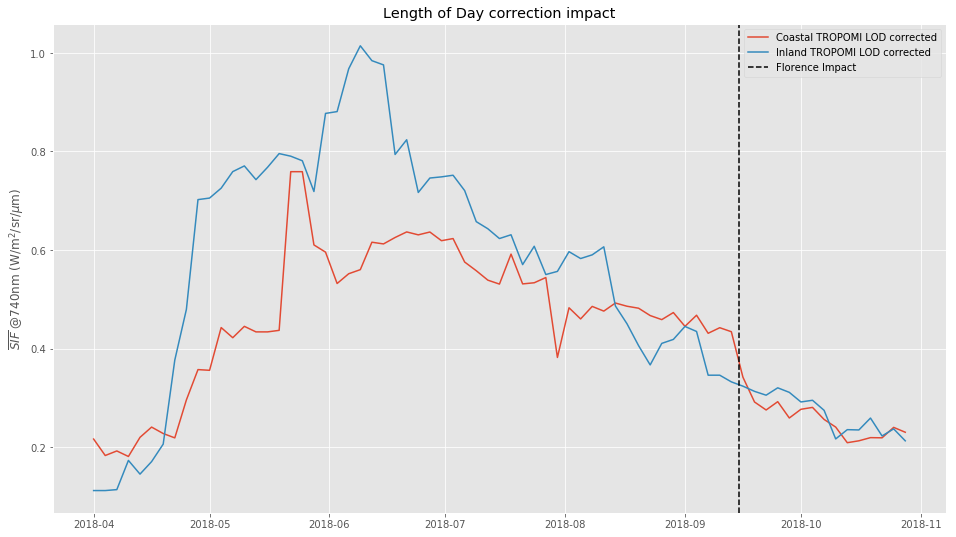

In [87]:
#plt.plot(dates, iowa_timeseries_oco2DC.mean*fac, label='OCO-2 LOD corrected')
plt.plot(dates, nc_coastal_timeseries_tropomi_dc.mean, label='Coastal TROPOMI LOD corrected')
plt.plot(dates, nc_inland_timeseries_tropomi_dc.mean, label='Inland TROPOMI LOD corrected')
plt.axvline(x=dt.date(2018, 9, 15),label='Florence Impact', c='black', linestyle="dashed")
plt.legend()
plt.ylabel('$\overline{SIF}$ @740nm (W/m$^2$/sr/$\mu$m)')
plt.title('Length of Day correction impact')